# Intuit Quickbooks Upgrade

In [1]:
import math

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyrsm as rsm
import seaborn as sns
import statsmodels.formula.api as smf
import xgboost as xgb
from scipy import stats
from sklearn import metrics, preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from statsmodels.genmod.families import Binomial
from statsmodels.genmod.families.links import logit
import pyrsm as rsm

# increase plot resolution
mpl.rcParams["figure.dpi"] = 150
rsm.__version__  # should be 0.7.2 or higher

'0.7.2'

In [129]:
## setup pyrsm for autoreload when you edit code and save
%reload_ext autoreload
%autoreload 2
%aimport pyrsm

In [3]:
## loading the data
intuit75k = pd.read_pickle("data/intuit75k.pkl")
# intuit75k = intuit75k.rename(columns={"zip": "zip5"})

rsm.describe(intuit75k)

## Intuit: Quickbooks upgrade

The purpose of this exercise is to gain experience modeling the response to an upsell campaign. The `intuit75k.pkl` file contains data on 75,000 (small) businesses that were selected randomly from the 801,821 that were sent the wave-1 mailing. The mailing contained an offer to upgrade to the latest version of the Quickbooks software.

Variable `res1` denotes which of these businesses responded to the mailing by purchasing Quickbooks version 3.0 from Intuit Direct. Note that Intuit Direct sells products directly to its customers rather than through a retailer. Use the available data to predict which businesses that did not respond to the wave-1 mailing, are most likely to respond to the wave-2 mailing. Note that variables were added, deleted, and recoded so please ignore the variable descriptions in Exhibit 3 in the case in the course reader. Instead, use the variable descriptions below:

## Variable description

* id: Small business customer ID
* zip5: 5-Digit ZIP Code (00000=unknown, 99999=international ZIPs).
* zip_bins: Zip-code bins (20 approx. equal sized bins from lowest to highest zip code number)
* sex: "Female", "Male", or "Unknown"
* bizflag: Business Flag.  Address contains a Business name (1 = yes, 0 = no or unknown).
* numords: Number of orders from Intuit Direct in the previous 36 months
* dollars: Total $ ordered from Intuit Direct in the previous 36 months
* last: Time (in months) since last order from Intuit Direct in previous 36 months
* sincepurch: Time (in months) since original (not upgrade) purchase of Quickbooks
* version1: Is 1 if customer's current Quickbooks is version 1, 0 if version 2
* owntaxprod: Is 1 if customer purchased tax software, 0 otherwise
* upgraded: Is 1 if customer upgraded from Quickbooks vs. 1 to vs. 2
* res1: Response to wave 1 mailing ("Yes" if responded else "No")
* training: 70/30 split, 1 for training sample, 0 for validation sample


In [4]:
intuit75k.head()

,id,zip5,zip_bins,sex,bizflag,numords,dollars,last,sincepurch,version1,owntaxprod,upgraded,res1,training,res1_yes
0,1,94553,18,Male,0,2,109.5,5,12,0,0,0,No,1,0
1,2,53190,10,Unknown,0,1,69.5,4,3,0,0,0,No,0,0
2,3,37091,8,Male,0,4,93.0,14,29,0,0,1,No,0,0
3,4,02125,1,Male,0,1,22.0,17,1,0,0,0,No,1,0
4,5,60201,11,Male,0,1,24.5,2,3,0,0,0,No,0,0


In [5]:
## loading the data
intuit75k = pd.read_pickle("data/intuit75k_res2-for-py.pkl")
intuit75k = intuit75k.rename(columns={"zip": "zip5"})
intuit75k.head()

,id,zip5,zip_bins,sex,bizflag,numords,dollars,last,sincepurch,version1,owntaxprod,upgraded,res1,res2,training
0,1,94553,18,Male,0,2,109.5,5,12,0,0,0,No,No,1
1,2,53190,10,Unknown,0,1,69.5,4,3,0,0,0,No,No,0
2,3,37091,8,Male,0,4,93.0,14,29,0,0,1,No,No,0
3,4,02125,1,Male,0,1,22.0,17,1,0,0,0,No,No,1
4,5,60201,11,Male,0,1,24.5,2,3,0,0,0,No,No,0


In [6]:
intuit75k.zip_bins.astype("category")

0        18
1        10
2         8
3         1
4        11
         ..
74995     6
74996    18
74997    13
74998     6
74999     7
Name: zip_bins, Length: 75000, dtype: category
Categories (20, object): ['1', '2', '3', '4', ..., '17', '18', '19', '20']

In [7]:
intuit75k["res1_yes"] = rsm.ifelse(intuit75k.res1 == "Yes", 1, 0)
intuit75k["res2_yes"] = rsm.ifelse(intuit75k.res2 == "Yes", 1, 0)
intuit75k.head()


,id,zip5,zip_bins,sex,bizflag,numords,dollars,last,sincepurch,version1,owntaxprod,upgraded,res1,res2,training,res1_yes,res2_yes
0,1,94553,18,Male,0,2,109.5,5,12,0,0,0,No,No,1,0,0
1,2,53190,10,Unknown,0,1,69.5,4,3,0,0,0,No,No,0,0,0
2,3,37091,8,Male,0,4,93.0,14,29,0,0,1,No,No,0,0,0
3,4,02125,1,Male,0,1,22.0,17,1,0,0,0,No,No,1,0,0
4,5,60201,11,Male,0,1,24.5,2,3,0,0,0,No,No,0,0,0


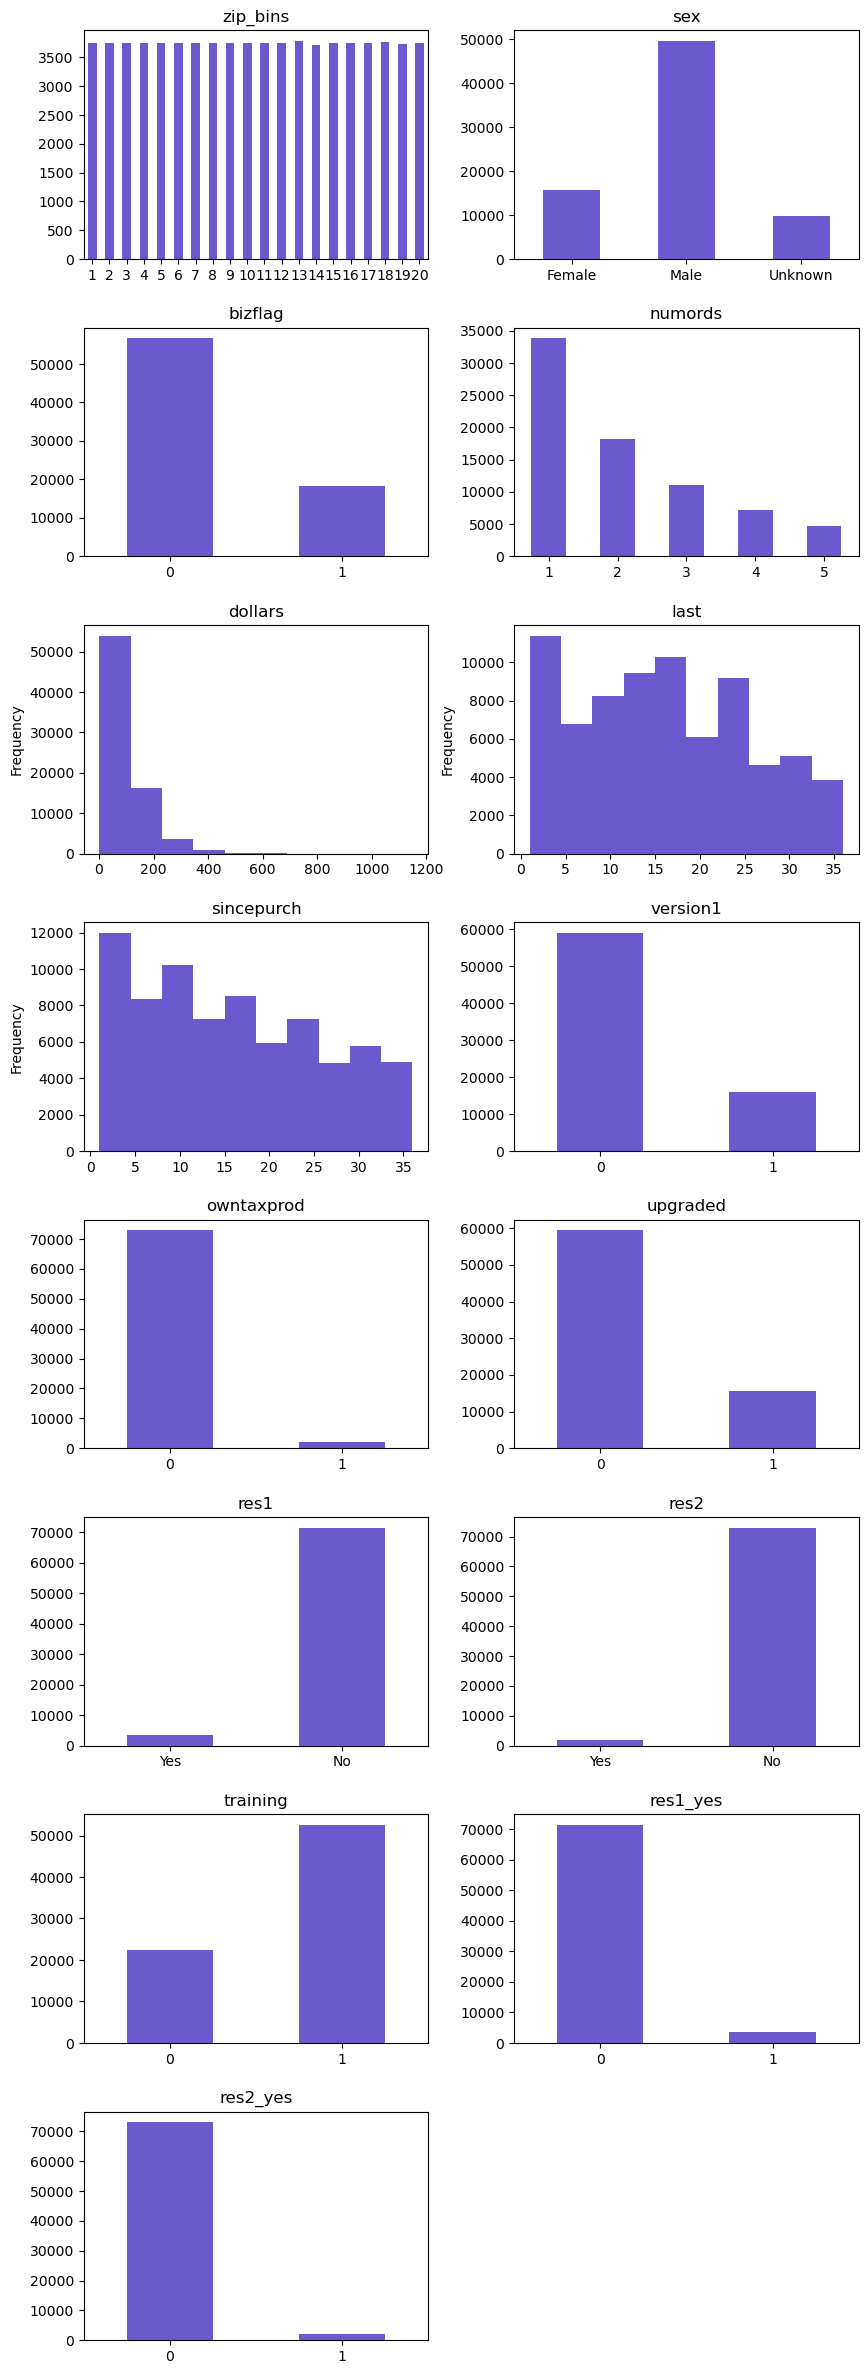

In [8]:
rsm.distr_plot(intuit75k.loc[:, "zip_bins":])

In [11]:
ct = rsm.cross_tabs(intuit75k.query("training == 1"), "res1", "sex")
ct.summary(output="perc_col")


Cross-tabs
Variables: res1, sex
Null hyp: there is no association between res1 and sex
Alt. hyp: there is an association between res1 and sex

Column percentages:

sex    Female    Male Unknown   Total
res1                                 
Yes      4.8%   4.76%    4.7%   4.76%
No      95.2%  95.24%   95.3%  95.24%
Total  100.0%  100.0%  100.0%  100.0%

Chi-squared: 0.1 df(2), p.value 0.95
0.0% of cells have expected values below 5



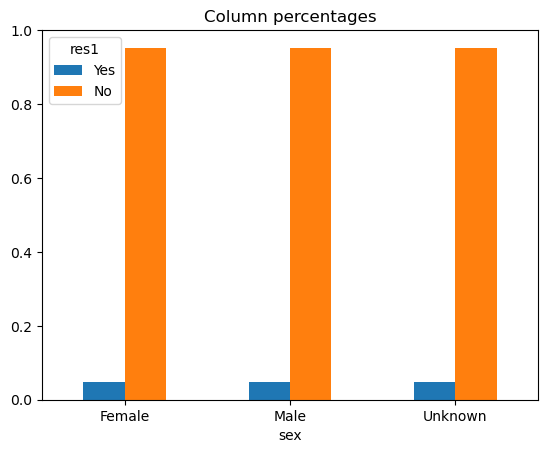

In [12]:
ct.plot(output="perc_col")

In [13]:
ct = rsm.cross_tabs(intuit75k.query("training == 1"), "res1", "bizflag")
ct.summary(output="perc_col")


Cross-tabs
Variables: res1, bizflag
Null hyp: there is no association between res1 and bizflag
Alt. hyp: there is an association between res1 and bizflag

Column percentages:

bizflag       0       1   Total
res1                           
Yes       4.71%   4.92%   4.76%
No       95.29%  95.08%  95.24%
Total    100.0%  100.0%  100.0%

Chi-squared: 1.01 df(1), p.value 0.32
0.0% of cells have expected values below 5



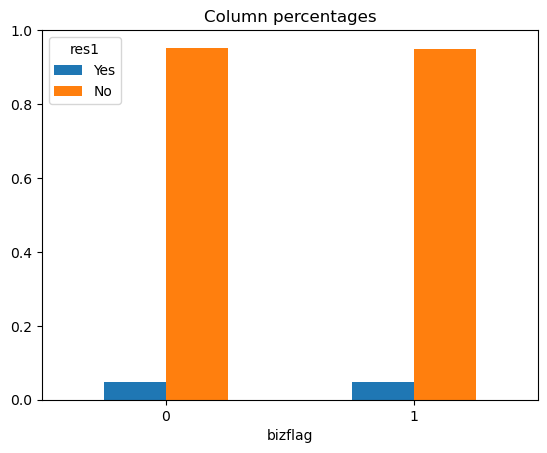

In [14]:
ct.plot(output="perc_col")

In [15]:
ct = rsm.cross_tabs(intuit75k.query("training == 1"), "res1", "version1")
ct.summary(output="perc_col")


Cross-tabs
Variables: res1, version1
Null hyp: there is no association between res1 and version1
Alt. hyp: there is an association between res1 and version1

Column percentages:

version1       0       1   Total
res1                            
Yes        4.33%   6.35%   4.76%
No        95.67%  93.65%  95.24%
Total     100.0%  100.0%  100.0%

Chi-squared: 79.91 df(1), p.value < .001
0.0% of cells have expected values below 5



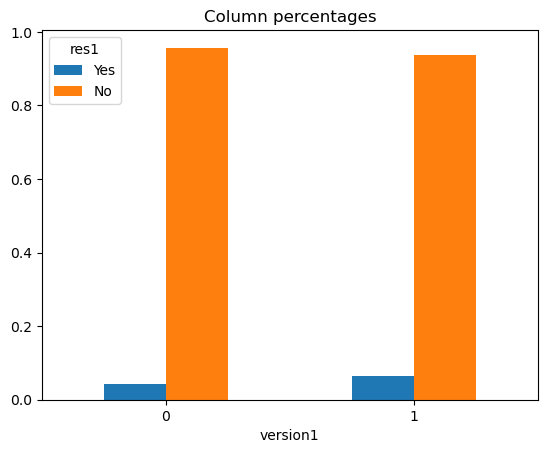

In [16]:
ct.plot(output="perc_col")

In [17]:
ct = rsm.cross_tabs(intuit75k.query("training == 1"), "res1", "owntaxprod")
ct.summary(output="perc_col")


Cross-tabs
Variables: res1, owntaxprod
Null hyp: there is no association between res1 and owntaxprod
Alt. hyp: there is an association between res1 and owntaxprod

Column percentages:

owntaxprod       0       1   Total
res1                              
Yes          4.66%   8.18%   4.76%
No          95.34%  91.82%  95.24%
Total       100.0%  100.0%  100.0%

Chi-squared: 40.07 df(1), p.value < .001
0.0% of cells have expected values below 5



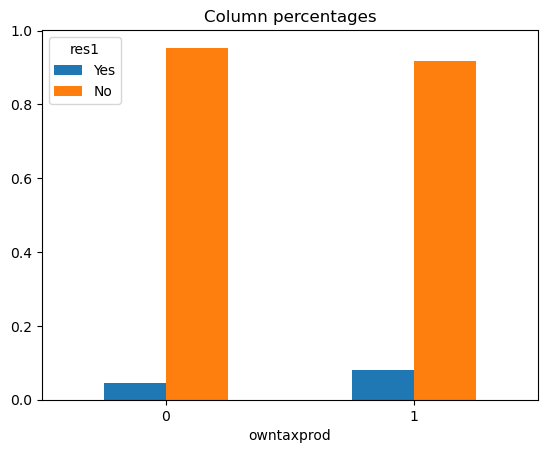

In [18]:
ct.plot(output="perc_col")

In [19]:
ct = rsm.cross_tabs(intuit75k.query("training == 1"), "res1", "upgraded")
ct.summary(output="perc_col")


Cross-tabs
Variables: res1, upgraded
Null hyp: there is no association between res1 and upgraded
Alt. hyp: there is an association between res1 and upgraded

Column percentages:

upgraded       0       1   Total
res1                            
Yes        3.99%    7.7%   4.76%
No        96.01%   92.3%  95.24%
Total     100.0%  100.0%  100.0%

Chi-squared: 262.79 df(1), p.value < .001
0.0% of cells have expected values below 5



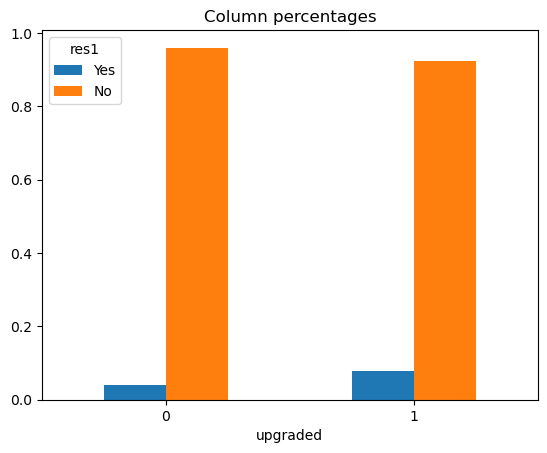

In [20]:
ct.plot(output="perc_col")

In [21]:
pd.crosstab(
    intuit75k.loc[intuit75k.training == 1, "version1"],
    intuit75k.loc[intuit75k.training == 1, "upgraded"],
    margins=True,
    margins_name="Total",
).applymap(lambda x: "{:,}".format(x))

upgraded,0,1,Total
version1,,,
0,"30,433","10,877","41,310"
1,"11,190",0,"11,190"
Total,"41,623","10,877","52,500"


In [22]:
ct = rsm.cross_tabs(intuit75k.query("training == 1"), "res1", "zip_bins")
ct.summary(output="perc_col")


Cross-tabs
Variables: res1, zip_bins
Null hyp: there is no association between res1 and zip_bins
Alt. hyp: there is an association between res1 and zip_bins

Column percentages:

zip_bins       1       2       3       4       5       6       7       8  \
res1                                                                       
Yes        21.7%    4.2%   3.37%   4.06%   3.35%   3.77%   3.52%   3.79%   
No         78.3%   95.8%  96.63%  95.94%  96.65%  96.23%  96.48%  96.21%   
Total     100.0%  100.0%  100.0%  100.0%  100.0%  100.0%  100.0%  100.0%   

zip_bins       9      10  ...      12      13      14      15      16      17  \
res1                      ...                                                   
Yes        3.68%   3.55%  ...   4.87%   3.27%   3.83%   3.45%   3.82%   3.88%   
No        96.32%  96.45%  ...  95.13%  96.73%  96.17%  96.55%  96.18%  96.12%   
Total     100.0%  100.0%  ...  100.0%  100.0%  100.0%  100.0%  100.0%  100.0%   

zip_bins      18      19      20 

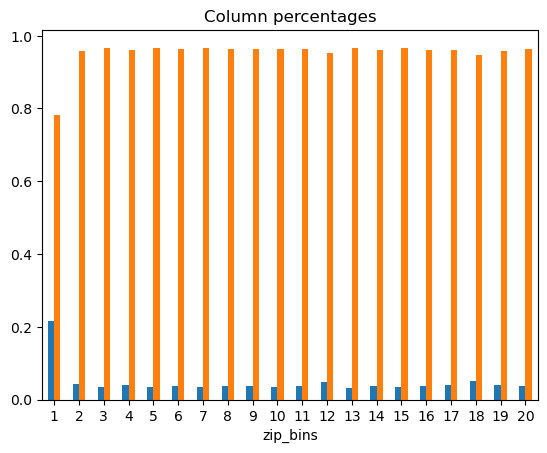

In [23]:
ct.plot(output="perc_col", legend=False)

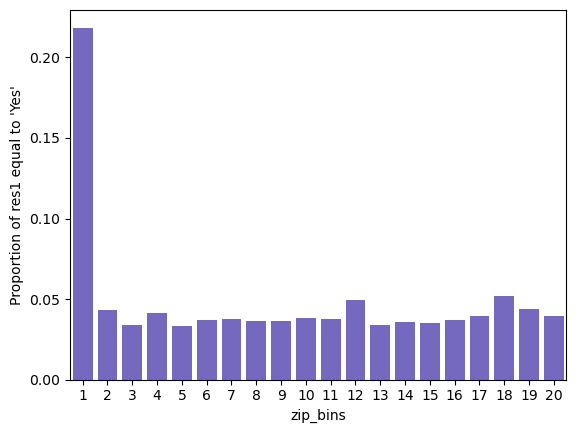

In [24]:
fig = rsm.prop_plot(intuit75k, "zip_bins", "res1", "Yes")

Is there an association between metric variables and response to wave 1?

In [25]:
reg = smf.ols(formula="numords ~ res1_yes", data=intuit75k.query("training == 1")).fit()
rsm.coef_ci(reg)

,index,coefficient,2.5%,97.5%,p.values,
1,res1_yes,0.523,0.473,0.572,< .001,***


In [26]:
cm = rsm.compare_means(
    intuit75k.query("training == 1"), 
    "res1", "numords", [("Yes", "No")], 
    "two-sided", 0.95
)
cm.summary()

Pairwise mean comparisons t-test
Variables: res1, numords
Confidence: 0.95
Adjustment: none
res1  mean     n  n_missing    sd    se    me
 Yes 2.568  2498          0 1.436 0.029 0.056
  No 2.046 50002          0 1.224 0.005 0.011
Null hyp. Alt. hyp.  diff  t.value p.value      df
 Yes = No Yes != No 0.523   17.863  < .001 2681.25


In [27]:
reg = smf.ols(formula="dollars ~ res1_yes", data=intuit75k.query("training == 1")).fit()
rsm.coef_ci(reg)

,index,coefficient,2.5%,97.5%,p.values,
1,res1_yes,25.533,22.29,28.776,< .001,***


In [28]:
cm = rsm.compare_means(intuit75k.query("training == 1"), "res1", "dollars", [("Yes", "No")], "two-sided", 0.95)
cm.summary()


Pairwise mean comparisons t-test
Variables: res1, dollars
Confidence: 0.95
Adjustment: none
res1    mean     n  n_missing      sd    se    me
 Yes 117.000  2498          0 103.241 2.066 4.049
  No  91.467 50002          0  79.422 0.355 0.696
Null hyp. Alt. hyp.   diff  t.value p.value       df
 Yes = No Yes != No 25.533   12.182  < .001 2646.718


In [29]:
reg = smf.ols(formula="last ~ res1_yes", data=intuit75k.query("training == 1")).fit()
rsm.coef_ci(reg)

,index,coefficient,2.5%,97.5%,p.values,
1,res1_yes,-4.026,-4.408,-3.644,< .001,***


In [30]:
cm = rsm.compare_means(intuit75k.query("training == 1"), "res1", "last", [("Yes", "No")], "two-sided", 0.95)
cm.summary()


Pairwise mean comparisons t-test
Variables: res1, last
Confidence: 0.95
Adjustment: none
res1   mean     n  n_missing    sd    se    me
 Yes 12.022  2498          0 8.942 0.179 0.351
  No 16.048 50002          0 9.536 0.043 0.084
Null hyp. Alt. hyp.   diff  t.value p.value       df
 Yes = No Yes != No -4.026  -21.889  < .001 2788.333


In [31]:
reg = smf.ols(
    formula="sincepurch ~ res1_yes", data=intuit75k.query("training == 1")
).fit()
rsm.coef_ci(reg)

,index,coefficient,2.5%,97.5%,p.values,
1,res1_yes,3.712,3.311,4.114,< .001,***


In [32]:
cm = rsm.compare_means(intuit75k.query("training == 1"), "res1", "sincepurch", [("Yes", "No")], "two-sided", 0.95)
cm.summary()


Pairwise mean comparisons t-test
Variables: res1, sincepurch
Confidence: 0.95
Adjustment: none
res1   mean     n  n_missing    sd    se    me
 Yes 19.153  2498          0 9.959 0.199 0.391
  No 15.440 50002          0 9.994 0.045 0.088
Null hyp. Alt. hyp.  diff  t.value p.value       df
 Yes = No Yes != No 3.712   18.179  < .001 2754.232


In [33]:
rsm.correlation(
    intuit75k.query("training == 1")[["last", "sincepurch", "version1", "upgraded"]]
).summary()

Correlation
Variables: last, sincepurch, version1, upgraded
Null hyp.: variables x and y are not correlated
Alt. hyp.: variables x and y are correlated

Correlation matrix:
            last sincepurch version1
sincepurch  -0.0                    
version1     0.0       0.52         
upgraded    -0.0       0.51    -0.27

p.values:
            last sincepurch version1
sincepurch  0.73                    
version1    0.89        0.0         
upgraded    0.75        0.0      0.0


In [34]:
# first logistic regression
lr = smf.glm(
    formula="""res1_yes ~ zip_bins + sex + bizflag + numords + dollars 
               + last + sincepurch + version1 + owntaxprod + upgraded""",
    family=Binomial(link=logit()),
    data=intuit75k.query("training == 1"),
).fit()
rsm.or_ci(lr)

,index,OR,OR%,2.5%,97.5%,p.values,
1,zip_bins[T.2],0.148,-85.2%,0.119,0.184,< .001,***
2,zip_bins[T.3],0.118,-88.2%,0.093,0.149,< .001,***
3,zip_bins[T.4],0.136,-86.4%,0.109,0.169,< .001,***
4,zip_bins[T.5],0.116,-88.4%,0.092,0.147,< .001,***
5,zip_bins[T.6],0.126,-87.4%,0.101,0.158,< .001,***
6,zip_bins[T.7],0.121,-87.9%,0.096,0.153,< .001,***
7,zip_bins[T.8],0.131,-86.9%,0.105,0.163,< .001,***
8,zip_bins[T.9],0.124,-87.6%,0.099,0.156,< .001,***
9,zip_bins[T.10],0.121,-87.9%,0.096,0.153,< .001,***
10,zip_bins[T.11],0.128,-87.2%,0.102,0.161,< .001,***


In [35]:
rsm.model_fit(lr)


Pseudo R-squared (McFadden): 0.114
Pseudo R-squared (McFadden adjusted): 0.111
Area under the RO Curve (AUC): 0.755
Log-likelihood: -8899.946, AIC: 17859.893, BIC: 18125.95
Chi-squared: 51307.819 df(29), p.value < 0.001 
Nr obs: 52,500



In [36]:
# second logistic regression
intuit75k["zip_bins"] = intuit75k.zip_bins.astype("category")
lr = smf.glm(
    formula="""res1_yes ~ zip_bins + sex + bizflag + numords + dollars 
               + last + sincepurch + version1 + owntaxprod + upgraded""",
    family=Binomial(link=logit()),
    data=intuit75k.query("training == 1"),
).fit()
rsm.or_ci(lr).iloc[0:5, :]
lr_base = lr

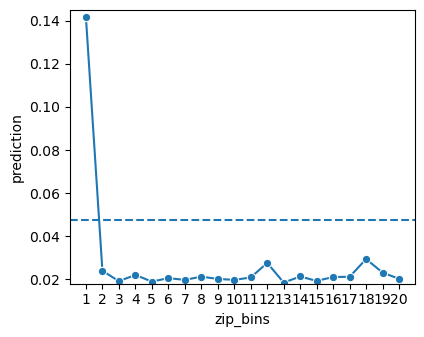

In [38]:
rsm.pred_plot_sm(
    lr, intuit75k[intuit75k.training == 1],
    incl = "zip_bins"
)

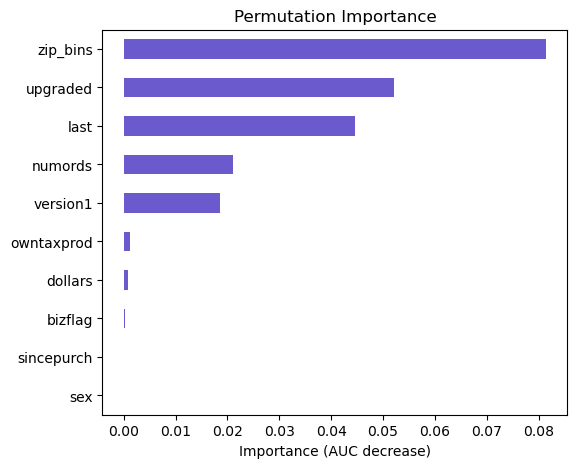

In [39]:
rsm.vimp_plot_sm(lr, intuit75k[intuit75k.training == 1])

In [40]:
rsm.model_fit(lr)


Pseudo R-squared (McFadden): 0.114
Pseudo R-squared (McFadden adjusted): 0.111
Area under the RO Curve (AUC): 0.755
Log-likelihood: -8899.946, AIC: 17859.893, BIC: 18125.95
Chi-squared: 51307.819 df(29), p.value < 0.001 
Nr obs: 52,500



In [41]:
# top 10 responses rate values per zip code in zip_bin 1
(
    intuit75k.query("(training == 1) & (zip_bins == '1')")
    .groupby("zip5")
    .agg(mean = ("res1_yes", np.mean), count=("res1_yes", "count"))
    .sort_values(by="mean", ascending=False)[0:10]
)

,mean,count
zip5,,
01950,0.500000,4
02144,0.500000,2
00801,0.411168,1182
01754,0.400000,5
01923,0.375000,8
00804,0.354331,127
02163,0.333333,3
02050,0.285714,7
01545,0.250000,4


In [42]:
# top 10 response counts per zip code
(
    intuit75k.query("(training == 1) & (zip_bins == '1')")
    .groupby("zip5")["res1_yes"]
    .agg(["mean", "sum", "count"])
    .sort_values(by="sum", ascending=False)[0:10]
)

,mean,sum,count
zip5,,,
00801,0.411168,486,1182
00804,0.354331,45,127
00000,0.030000,3,100
01923,0.375000,3,8
01890,0.176471,3,17
02050,0.285714,2,7
01950,0.500000,2,4
01752,0.133333,2,15
01754,0.400000,2,5


In [43]:
df = intuit75k.query("(training == 1) & (zip_bins == '1')")
pd.crosstab(df.zip5, df.res1, normalize="columns",).sort_values(
    "Yes", ascending=False
).apply(lambda x: (100 * x).round(2).astype(str) + "%")

res1,Yes,No
zip5,,
00801,84.08%,33.37%
00804,7.79%,3.93%
00000,0.52%,4.65%
01923,0.52%,0.24%
01890,0.52%,0.67%
...,...,...
01027,0.0%,0.38%
01028,0.0%,0.05%
01749,0.0%,0.14%


In [45]:
# third logistic regression
intuit75k = intuit75k.assign(
    zip801=rsm.ifelse(intuit75k.zip5 == "00801", 1, 0),
    zip804=rsm.ifelse(intuit75k.zip5 == "00804", 1, 0)
)
lr = smf.glm(
    formula="""res1_yes ~ zip_bins + sex + bizflag + numords + dollars 
               + last + sincepurch + version1 + owntaxprod + upgraded 
               + zip801 + zip804 """,
    family=Binomial(link=logit()),
    data=intuit75k.query("training == 1"),
).fit()
rsm.or_ci(lr).iloc[29:]

,index,OR,OR%,2.5%,97.5%,p.values,
30,zip801,25.333,2433.3%,18.38,34.915,< .001,***
31,zip804,18.398,1739.8%,11.30,29.957,< .001,***


In [46]:
rsm.or_ci(lr).iloc[:19]

,index,OR,OR%,2.5%,97.5%,p.values,
1,zip_bins[T.2],1.300,30.0%,0.914,1.850,0.145,
2,zip_bins[T.3],1.031,3.1%,0.715,1.487,0.869,
3,zip_bins[T.4],1.189,18.9%,0.834,1.695,0.339,
4,zip_bins[T.5],1.020,2.0%,0.708,1.470,0.913,
5,zip_bins[T.6],1.107,10.7%,0.774,1.583,0.578,
6,zip_bins[T.7],1.063,6.3%,0.741,1.526,0.741,
7,zip_bins[T.8],1.147,14.7%,0.802,1.639,0.453,
8,zip_bins[T.9],1.088,8.8%,0.759,1.561,0.645,
9,zip_bins[T.10],1.063,6.3%,0.741,1.527,0.739,
10,zip_bins[T.11],1.126,12.6%,0.786,1.614,0.518,


In [47]:
lr.wald_test_terms(scalar=True).table.round(3)

,statistic,pvalue,df_constraint
Intercept,528.668,0.000,1
zip_bins,32.261,0.029,19
sex,0.336,0.845,2
bizflag,0.842,0.359,1
numords,161.452,0.000,1
dollars,17.180,0.000,1
last,334.838,0.000,1
sincepurch,0.269,0.604,1
version1,76.721,0.000,1
owntaxprod,9.683,0.002,1


In [48]:
# fourth logistic regression
lr = smf.glm(
    formula="""res1_yes ~ zip_bins + sex + bizflag + numords + dollars 
               + last + sincepurch + version1 + owntaxprod + upgraded 
               + zip801 + zip804 + numords:version1 + last:version1""",
    family=Binomial(link=logit()),
    data=intuit75k.query("training == 1"),
).fit()
rsm.or_ci(lr).iloc[[22, 24, 26, 31, 32]]

,index,OR,OR%,2.5%,97.5%,p.values,
23,numords,1.162,16.2%,1.112,1.214,< .001,***
25,last,0.966,-3.4%,0.960,0.971,< .001,***
27,version1,1.474,47.4%,1.097,1.981,0.01,*
32,numords:version1,1.397,39.7%,1.303,1.498,< .001,***
33,last:version1,0.959,-4.1%,0.948,0.970,< .001,***


In [49]:
# final logistic regression
lr_mod = smf.glm(
    formula="""res1_yes ~ zip_bins + numords + dollars + last 
               + version1 + owntaxprod + upgraded + zip801 + zip804 
               + numords:version1 + last:version1""",
    family=Binomial(link=logit()),
    data=intuit75k.query("training == 1"),
)
lr = lr_mod.fit()

In [50]:
rsm.or_ci(lr).iloc[[0, 18] + list(range(19, 29))]

,index,OR,OR%,2.5%,97.5%,p.values,
1,zip_bins[T.2],1.295,29.5%,0.909,1.845,0.152,
19,zip_bins[T.20],1.085,8.5%,0.756,1.556,0.658,
20,numords,1.162,16.2%,1.112,1.214,< .001,***
21,dollars,1.001,0.1%,1.001,1.002,< .001,***
22,last,0.966,-3.4%,0.960,0.971,< .001,***
23,version1,1.531,53.1%,1.178,1.990,0.001,**
24,owntaxprod,1.499,49.9%,1.221,1.840,< .001,***
25,upgraded,2.823,182.3%,2.550,3.126,< .001,***
26,zip801,25.883,2488.3%,18.765,35.702,< .001,***
27,zip804,18.296,1729.6%,11.217,29.844,< .001,***


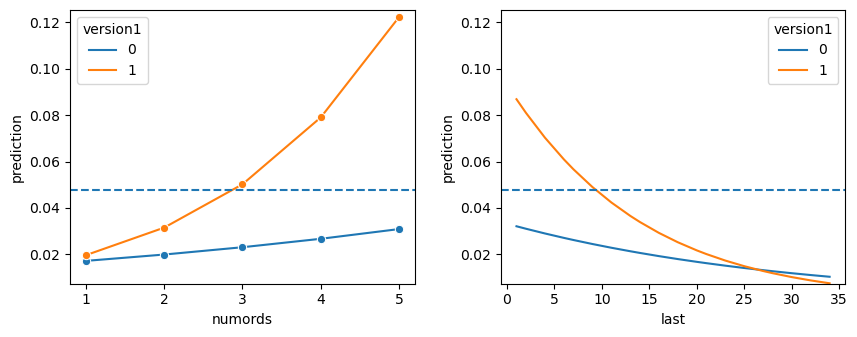

In [51]:
rsm.pred_plot_sm(
    lr, intuit75k[intuit75k.training == 1],
    incl=[],
    incl_int=["numords:version1", "last:version1"]
)

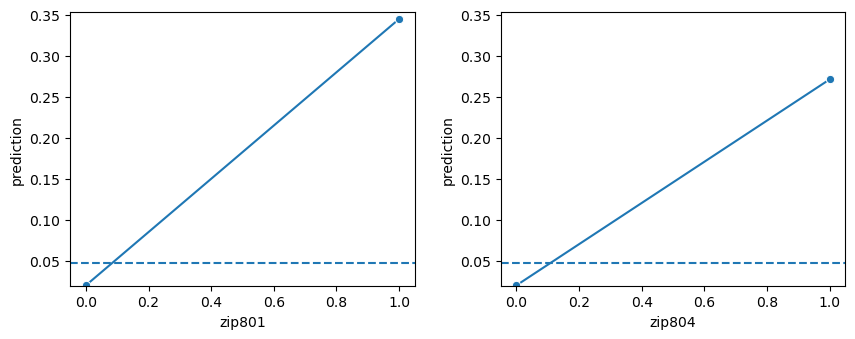

In [52]:
rsm.pred_plot_sm(
    lr, intuit75k[intuit75k.training == 1],
    incl=["zip801", "zip804"]
)

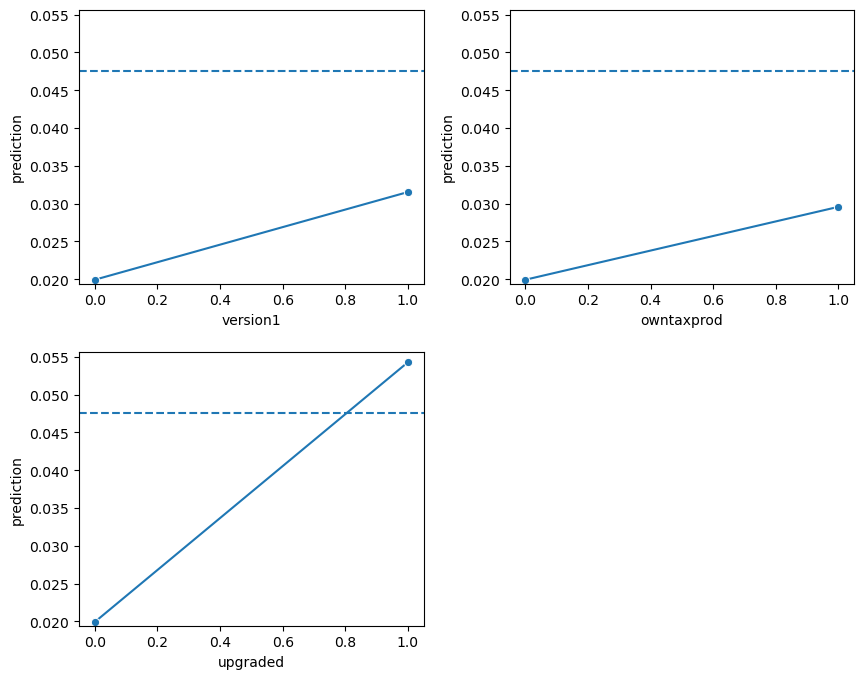

In [53]:
rsm.pred_plot_sm(
    lr, intuit75k[intuit75k.training == 1],
    incl=["version1", "owntaxprod", "upgraded"]
)

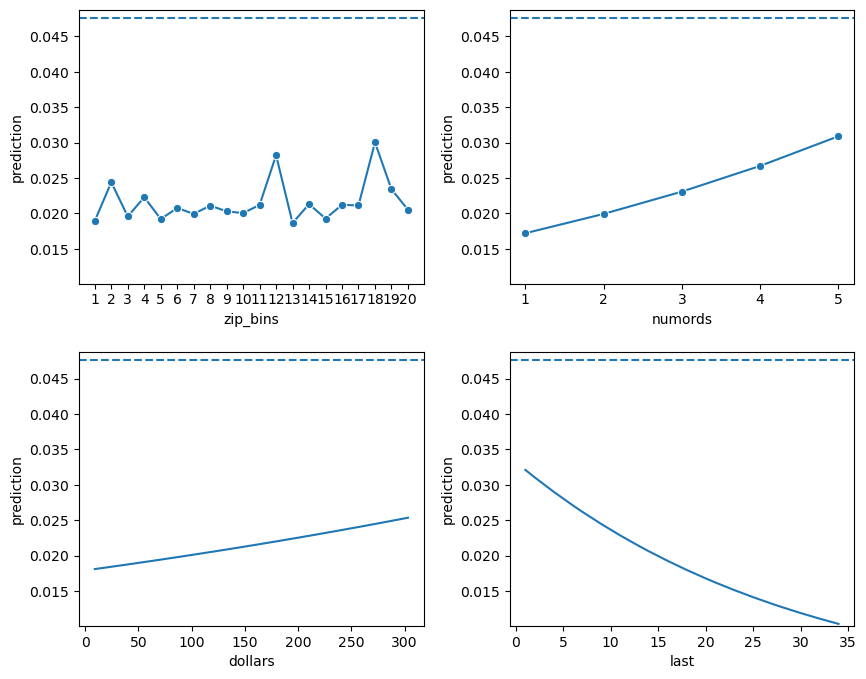

In [54]:
rsm.pred_plot_sm(
    lr, intuit75k[intuit75k.training == 1],
    incl=["zip_bins", "numords", "dollars", "last"]
)

In [55]:
rsm.model_fit(lr)


Pseudo R-squared (McFadden): 0.156
Pseudo R-squared (McFadden adjusted): 0.153
Area under the RO Curve (AUC): 0.774
Log-likelihood: -8480.445, AIC: 17020.891, BIC: 17286.948
Chi-squared: 51678.63 df(29), p.value < 0.001 
Nr obs: 52,500



In [56]:
lr.predict().mean()

0.04758095238095667

[Text(0.5, 0, '')]

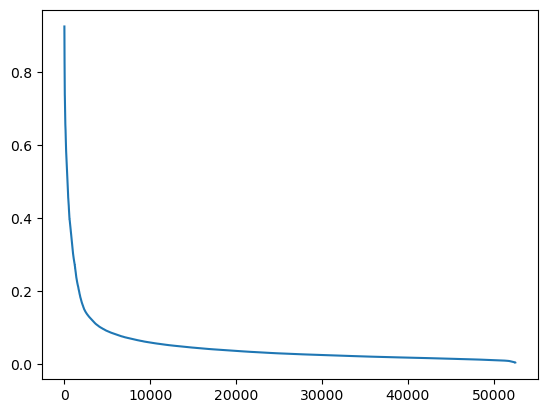

In [57]:
fig = (
    pd.DataFrame()
    .assign(pred_logit=lr.predict())
    .sort_values("pred_logit", ascending=False)
    .assign(x=np.arange(lr.model.exog.shape[0]))
    .plot.line(y="pred_logit", x="x", legend=False)
)
#fig.axhline(y=1.4/60, linestyle="--")
fig.set(xlabel="")


[Text(0.5, 0, '')]

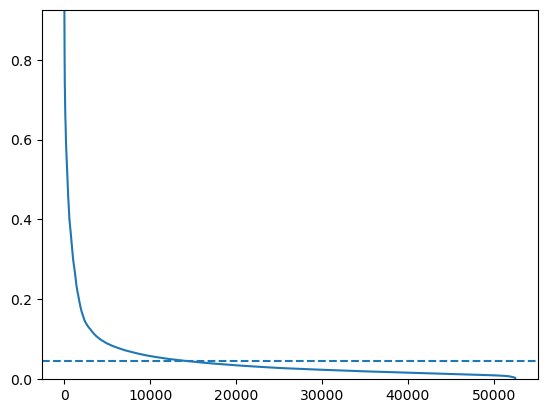

In [58]:
fig = (
    pd.DataFrame()
    .assign(pred_logit=lr.predict())
    .sort_values("pred_logit", ascending=False)
    .assign(x=np.arange(lr.model.exog.shape[0]))
    .plot.line(y="pred_logit", x="x", legend=False)
)
fig.axhline(y=1.41/30, linestyle="--")
fig.set(ylim=(0,lr.predict().max()))
fig.set(xlabel="")


[(0.0, 0.9251897595582688)]

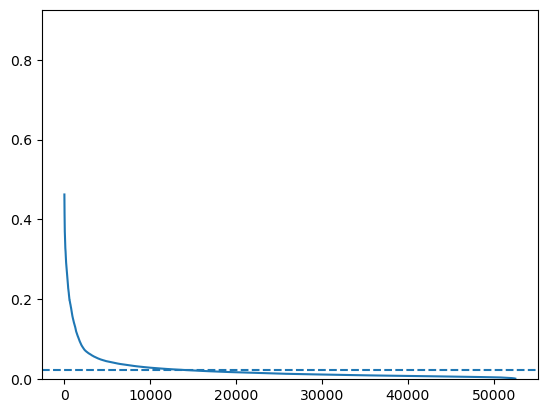

In [59]:
fig = (
    pd.DataFrame()
    .assign(pred_logit=lr.predict() / 2)
    .sort_values("pred_logit", ascending=False)
    .assign(x=np.arange(lr.model.exog.shape[0]))
    .plot.line(y="pred_logit", x="x", legend=False)
)
fig.axhline(y=1.41/60, linestyle="--")
fig.set(xlabel="")
fig.set(ylim=(0,lr.predict().max()))


## Neural networks

In [66]:
def nn(X, y, hlsizes=(1,), alpha=0.0001, max_iter=1000):
    return MLPClassifier(
        activation="tanh",
        solver="lbfgs",
        hidden_layer_sizes=hlsizes,
        alpha=alpha,
        random_state=1234,
        max_iter=max_iter,
    ).fit(X, y)


In [79]:
# create dummy variables
Xs = rsm.scale_df(intuit75k.loc[:, "bizflag":"upgraded"], sf=1, train=intuit75k.training == 1, excl = ["sex", "bizflag", "version1", "owntaxprod", "upgraded"])
Xs

,bizflag,numords,dollars,last,sincepurch,version1,owntaxprod,upgraded
0,0,-0.057079,0.207902,-1.137183,-0.360809,0,0,0
1,0,-0.863720,-0.286561,-1.241930,-1.258669,0,0,0
2,0,1.556202,0.003936,-0.194459,1.335150,0,0,1
3,0,-0.863720,-0.873735,0.119783,-1.458194,0,0,0
4,0,-0.863720,-0.842831,-1.451425,-1.258669,0,0,0
...,...,...,...,...,...,...,...,...
74995,1,1.556202,1.468781,-1.137183,-0.061522,0,0,0
74996,0,-0.863720,-1.090062,2.005232,1.833961,1,0,0
74997,1,-0.863720,-0.471984,-1.241930,0.337527,1,0,0
74998,0,-0.863720,-0.286561,0.434024,1.135625,0,0,1


In [84]:
Xs = Xs.assign(
    zip801=rsm.ifelse(intuit75k.zip5 == "00801", 1, 0),
    zip804=rsm.ifelse(intuit75k.zip5 == "00804", 1, 0)
)
Xs = pd.concat(
    [
        Xs,
        pd.get_dummies(intuit75k["sex"], prefix="sex", drop_first=True),
        pd.get_dummies(intuit75k["zip_bins"], prefix="zip_bins", drop_first=True),
    ],
    axis=1,
)
y = rsm.ifelse(intuit75k.res1 == "Yes", 1, 0)
y

Xs

,bizflag,numords,dollars,last,sincepurch,version1,owntaxprod,upgraded,zip801,zip804,...,zip_bins_11,zip_bins_12,zip_bins_13,zip_bins_14,zip_bins_15,zip_bins_16,zip_bins_17,zip_bins_18,zip_bins_19,zip_bins_20
0,0,-0.057079,0.207902,-1.137183,-0.360809,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,-0.863720,-0.286561,-1.241930,-1.258669,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1.556202,0.003936,-0.194459,1.335150,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,-0.863720,-0.873735,0.119783,-1.458194,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,-0.863720,-0.842831,-1.451425,-1.258669,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74995,1,1.556202,1.468781,-1.137183,-0.061522,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
74996,0,-0.863720,-1.090062,2.005232,1.833961,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
74997,1,-0.863720,-0.471984,-1.241930,0.337527,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
74998,0,-0.863720,-0.286561,0.434024,1.135625,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [86]:
# set up scaling using scale_df
# then apply get_dummies to X_train etc.
y.sum()

3601

In [88]:
clf = nn(Xs[intuit75k.training == 1], y[intuit75k.training == 1], hlsizes=(1,), max_iter=1000)
pred = pd.DataFrame().assign(
    training=intuit75k.training, nn1=clf.predict_proba(Xs)[:, 1]
)
pred.nn1.max()



0.6685250380388953

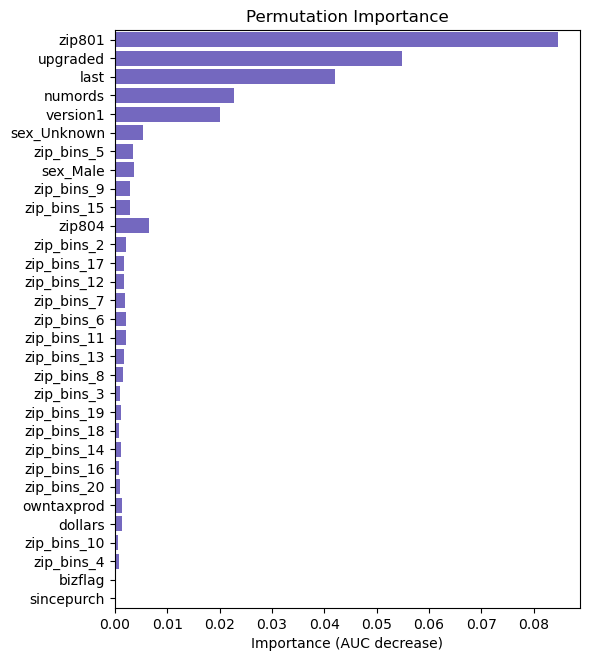

In [89]:
rsm.vimp_plot_sk(clf, Xs[intuit75k.training == 1], y[intuit75k.training == 1])

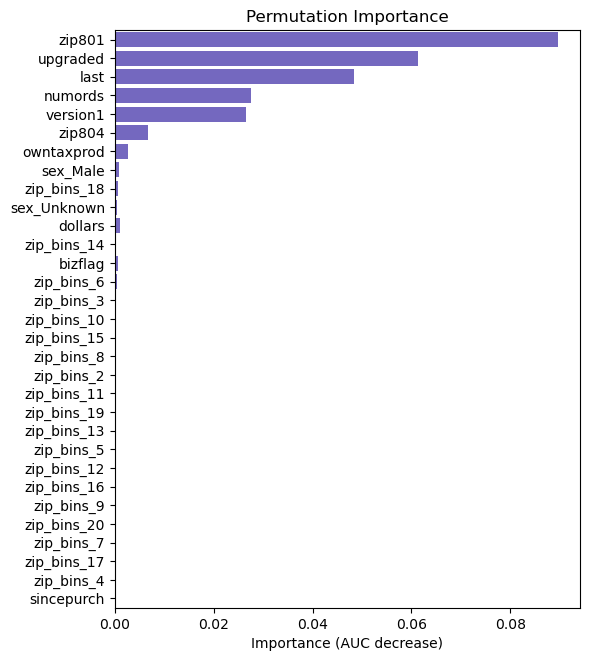

In [90]:
clf = nn(Xs[intuit75k.training == 1], y[intuit75k.training == 1], hlsizes=(2,), max_iter=1000)
pred = pred.assign(nn2=clf.predict_proba(Xs)[:, 1])
rsm.vimp_plot_sk(clf, Xs[intuit75k.training == 1], y[intuit75k.training == 1])

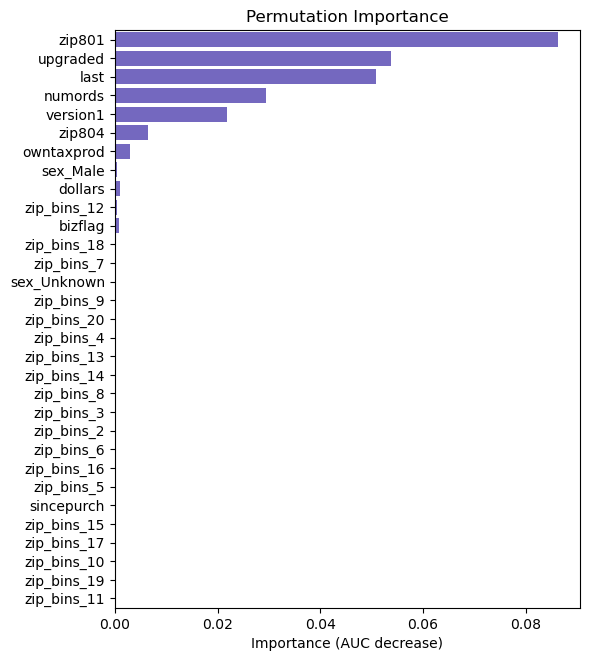

In [91]:
clf = nn(Xs[intuit75k.training == 1], y[intuit75k.training == 1], hlsizes=(3,), max_iter=1000)
pred = pred.assign(nn3=clf.predict_proba(Xs)[:, 1])
rsm.vimp_plot_sk(clf, Xs[intuit75k.training == 1], y[intuit75k.training == 1])


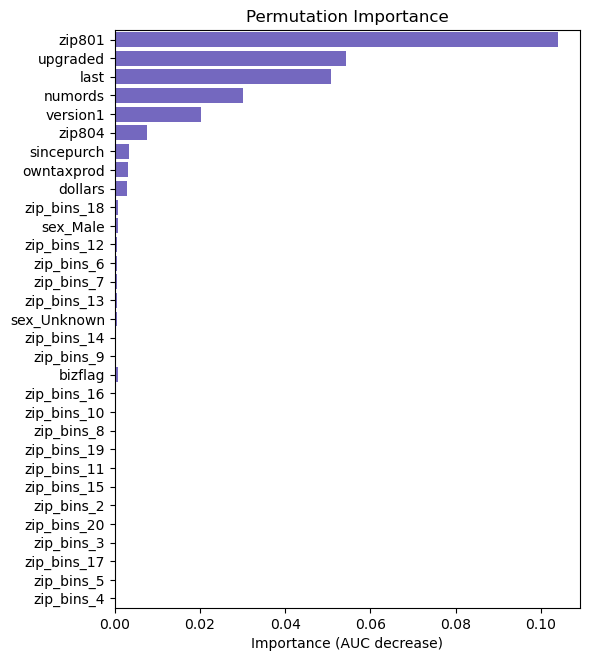

In [92]:
clf = nn(Xs[intuit75k.training == 1], y[intuit75k.training == 1], hlsizes=(4,), max_iter=1000)
pred = pred.assign(nn4=clf.predict_proba(Xs)[:, 1])
rsm.vimp_plot_sk(clf, Xs[intuit75k.training == 1], y[intuit75k.training == 1])


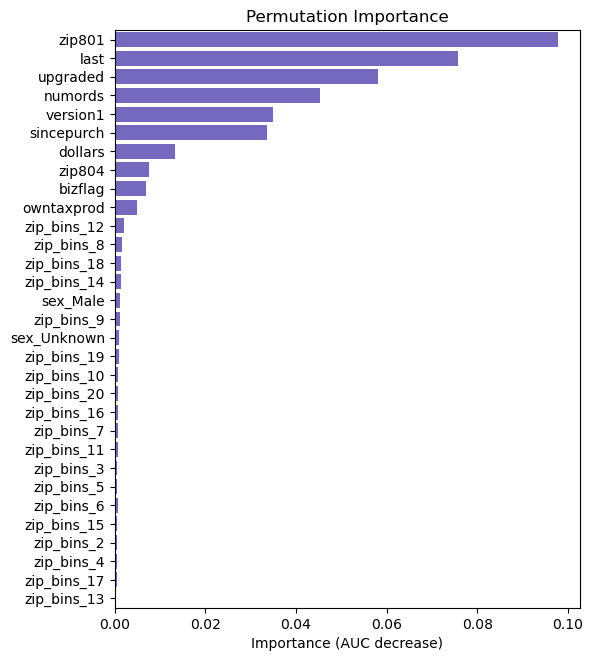

In [93]:
clf = nn(Xs[intuit75k.training == 1], y[intuit75k.training == 1], hlsizes=(10,), max_iter=1000)
pred = pred.assign(nn10=clf.predict_proba(Xs)[:, 1])
rsm.vimp_plot_sk(clf, Xs[intuit75k.training == 1], y[intuit75k.training == 1])

In [94]:
nr_hnodes = range(1, 7)
hls = list(zip(nr_hnodes))
hls

[(1,), (2,), (3,), (4,), (5,), (6,)]

In [95]:
clf = nn(Xs[intuit75k.training == 1], y[intuit75k.training == 1], hlsizes=(1,), max_iter=10000)
param_grid = {"hidden_layer_sizes": hls}
scoring = {"AUC": "roc_auc"}

clf_cv = GridSearchCV(
    clf, param_grid, scoring=scoring, cv=5, n_jobs=4, refit="AUC", verbose=5
).fit(Xs[intuit75k.training == 1], y[intuit75k.training == 1])

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 4/5] END ......hidden_layer_sizes=(1,); AUC: (test=0.763) total time=   0.3s
[CV 1/5] END ......hidden_layer_sizes=(1,); AUC: (test=0.748) total time=   0.3s
[CV 3/5] END ......hidden_layer_sizes=(1,); AUC: (test=0.773) total time=   0.4s
[CV 2/5] END ......hidden_layer_sizes=(1,); AUC: (test=0.757) total time=   0.4s
[CV 5/5] END ......hidden_layer_sizes=(1,); AUC: (test=0.777) total time=   0.2s
[CV 1/5] END ......hidden_layer_sizes=(2,); AUC: (test=0.758) total time=   0.4s
[CV 3/5] END ......hidden_layer_sizes=(2,); AUC: (test=0.783) total time=   0.4s
[CV 2/5] END ......hidden_layer_sizes=(2,); AUC: (test=0.768) total time=   0.5s
[CV 4/5] END ......hidden_layer_sizes=(2,); AUC: (test=0.767) total time=   0.4s
[CV 5/5] END ......hidden_layer_sizes=(2,); AUC: (test=0.775) total time=   0.4s
[CV 1/5] END ......hidden_layer_sizes=(3,); AUC: (test=0.750) total time=   0.7s
[CV 2/5] END ......hidden_layer_sizes=(3,); AUC: 

In [96]:
clf_cv.best_params_

{'hidden_layer_sizes': (2,)}

In [97]:
clf_cv.best_score_

0.7700846348601131

In [103]:
clf = nn(Xs[intuit75k.training == 1], y[intuit75k.training == 1], hlsizes=(1,), max_iter=10000)
nr_hnodes = range(1, 7)
hls 
param_grid = {"hidden_layer_sizes": hls, "alpha": np.arange(0, 1.1, 0.1)}
param_grid


{'hidden_layer_sizes': [(1,),
  (2,),
  (3,),
  (4,),
  (5,),
  (6,),
  (1, 1),
  (2, 2),
  (3, 3),
  (4, 4),
  (5, 5),
  (6, 6),
  (1, 1, 1),
  (2, 2, 2),
  (3, 3, 3),
  (4, 4, 4),
  (5, 5, 5),
  (6, 6, 6)],
 'alpha': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])}

In [104]:
profit_scorer = metrics.make_scorer(
    rsm.profit, greater_is_better=True, needs_proba=True, lev=1, cost=1.41, margin=30
)
scoring = {"Profit": profit_scorer}

clf_cv = GridSearchCV(
    clf, param_grid, scoring=scoring, cv=5, n_jobs=4, refit="Profit", verbose=5
).fit(Xs[intuit75k.training == 1], y[intuit75k.training == 1])

Fitting 5 folds for each of 198 candidates, totalling 990 fits
[CV 3/5] END alpha=0.0, hidden_layer_sizes=(1,); Profit: (test=5958.960) total time=   0.3s
[CV 1/5] END alpha=0.0, hidden_layer_sizes=(1,); Profit: (test=5073.540) total time=   0.4s
[CV 2/5] END alpha=0.0, hidden_layer_sizes=(1,); Profit: (test=5620.350) total time=   0.4s
[CV 4/5] END alpha=0.0, hidden_layer_sizes=(1,); Profit: (test=5645.730) total time=   0.3s
[CV 5/5] END alpha=0.0, hidden_layer_sizes=(1,); Profit: (test=5798.250) total time=   0.2s
[CV 1/5] END alpha=0.0, hidden_layer_sizes=(2,); Profit: (test=5207.310) total time=   0.4s
[CV 3/5] END alpha=0.0, hidden_layer_sizes=(2,); Profit: (test=6219.930) total time=   0.4s
[CV 2/5] END alpha=0.0, hidden_layer_sizes=(2,); Profit: (test=5837.220) total time=   0.5s
[CV 4/5] END alpha=0.0, hidden_layer_sizes=(2,); Profit: (test=5695.140) total time=   0.5s
[CV 5/5] END alpha=0.0, hidden_layer_sizes=(2,); Profit: (test=5851.170) total time=   0.4s
[CV 1/5] END alph

/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 5/5] END alpha=0.0, hidden_layer_sizes=(4, 4, 4); Profit: (test=5514.930) total time= 2.5min
[CV 2/5] END alpha=0.0, hidden_layer_sizes=(5, 5, 5); Profit: (test=5092.740) total time= 1.5min
[CV 1/5] END alpha=0.0, hidden_layer_sizes=(6, 6, 6); Profit: (test=4379.430) total time=  33.2s
[CV 4/5] END alpha=0.0, hidden_layer_sizes=(5, 5, 5); Profit: (test=4592.070) total time=  42.9s
[CV 3/5] END alpha=0.0, hidden_layer_sizes=(5, 5, 5); Profit: (test=5059.920) total time= 2.4min
[CV 4/5] END alpha=0.0, hidden_layer_sizes=(6, 6, 6); Profit: (test=5079.180) total time=  34.8s
[CV 5/5] END alpha=0.0, hidden_layer_sizes=(5, 5, 5); Profit: (test=5200.740) total time= 2.3min
[CV 1/5] END alpha=0.1, hidden_layer_sizes=(1,); Profit: (test=5043.540) total time=   0.3s
[CV 2/5] END alpha=0.1, hidden_layer_sizes=(1,); Profit: (test=5577.660) total time=   0.3s
[CV 3/5] END alpha=0.1, hidden_layer_sizes=(1,); Profit: (test=5939.220) total time=   0.3s
[CV 4/5] END alpha=0.1, hidden_layer_sizes=(1

/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/5] END alpha=0.0, hidden_layer_sizes=(6, 6, 6); Profit: (test=4553.730) total time= 3.8min
[CV 1/5] END alpha=0.1, hidden_layer_sizes=(4, 4, 4); Profit: (test=4704.150) total time=   9.6s
[CV 3/5] END alpha=0.1, hidden_layer_sizes=(3, 3, 3); Profit: (test=5845.080) total time=  54.3s
[CV 2/5] END alpha=0.1, hidden_layer_sizes=(4, 4, 4); Profit: (test=5223.720) total time=   5.0s


/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/5] END alpha=0.0, hidden_layer_sizes=(6, 6, 6); Profit: (test=4939.620) total time= 3.8min
[CV 4/5] END alpha=0.1, hidden_layer_sizes=(4, 4, 4); Profit: (test=5178.120) total time=  13.0s
[CV 1/5] END alpha=0.1, hidden_layer_sizes=(5, 5, 5); Profit: (test=4827.150) total time=  35.8s
[CV 3/5] END alpha=0.1, hidden_layer_sizes=(4, 4, 4); Profit: (test=5862.570) total time=  57.6s
[CV 5/5] END alpha=0.1, hidden_layer_sizes=(4, 4, 4); Profit: (test=5269.920) total time=  56.8s
[CV 4/5] END alpha=0.1, hidden_layer_sizes=(5, 5, 5); Profit: (test=5295.060) total time=  50.1s
[CV 5/5] END alpha=0.1, hidden_layer_sizes=(5, 5, 5); Profit: (test=5346.990) total time=  59.3s
[CV 3/5] END alpha=0.1, hidden_layer_sizes=(5, 5, 5); Profit: (test=5111.160) total time= 1.3min
[CV 3/5] END alpha=0.1, hidden_layer_sizes=(6, 6, 6); Profit: (test=4877.190) total time=  29.9s
[CV 2/5] END alpha=0.1, hidden_layer_sizes=(6, 6, 6); Profit: (test=5177.790) total time=  39.2s
[CV 4/5] END alpha=0.1, hidden

/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/5] END alpha=0.1, hidden_layer_sizes=(6, 6, 6); Profit: (test=4278.510) total time= 3.9min
[CV 2/5] END alpha=0.2, hidden_layer_sizes=(5, 5, 5); Profit: (test=4980.660) total time=  25.7s
[CV 3/5] END alpha=0.2, hidden_layer_sizes=(5, 5, 5); Profit: (test=5241.600) total time=  14.5s
[CV 4/5] END alpha=0.2, hidden_layer_sizes=(5, 5, 5); Profit: (test=5262.780) total time=  24.6s
[CV 5/5] END alpha=0.1, hidden_layer_sizes=(6, 6, 6); Profit: (test=5147.190) total time= 3.6min
[CV 1/5] END alpha=0.2, hidden_layer_sizes=(6, 6, 6); Profit: (test=4222.560) total time=  12.6s
[CV 5/5] END alpha=0.2, hidden_layer_sizes=(5, 5, 5); Profit: (test=5348.400) total time=  32.7s
[CV 1/5] END alpha=0.2, hidden_layer_sizes=(5, 5, 5); Profit: (test=4583.310) total time= 1.3min
[CV 4/5] END alpha=0.2, hidden_layer_sizes=(6, 6, 6); Profit: (test=5022.240) total time=  22.0s
[CV 1/5] END alpha=0.30000000000000004, hidden_layer_sizes=(1,); Profit: (test=5088.030) total time=   0.3s
[CV 2/5] END alpha=

In [105]:
clf_cv.best_params_

{'alpha': 0.4, 'hidden_layer_sizes': (2, 2, 2)}

In [106]:
clf_cv.best_score_

5804.676000000001

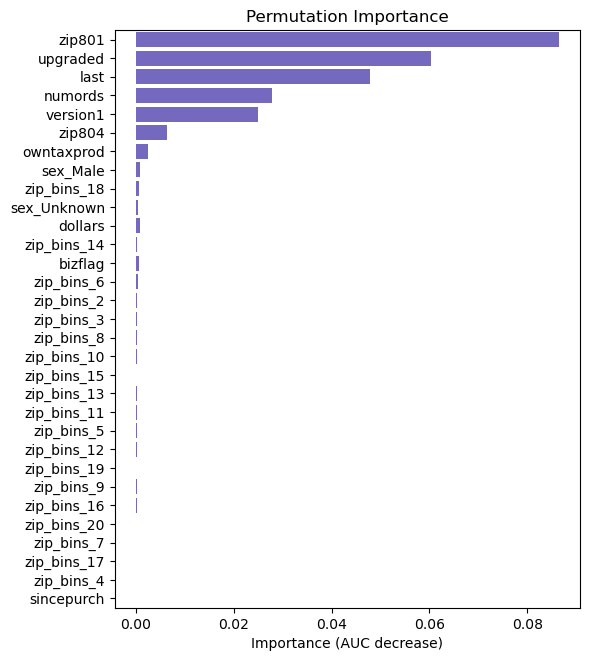

In [167]:
# clf = nn(X_train, y_train, hlsizes=(2,), alpha = 0.8, max_iter=1000)
clf = nn(Xs[intuit75k.training == 1], y[intuit75k.training == 1], hlsizes=(2,), alpha=0.8, max_iter=10000)
# clf = nn(Xs[intuit75k.training == 1], y[intuit75k.training == 1], hlsizes=(2, 2, 2,), alpha=0.4, max_iter=10000)
rsm.vimp_plot_sk(clf, Xs[intuit75k.training == 1], y[intuit75k.training == 1])

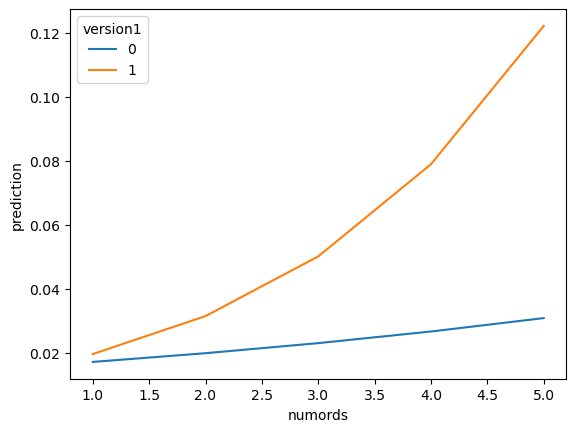

In [108]:
iplot = rsm.sim_prediction(
    intuit75k.query("training == 1"), vary=["numords", "version1"]
)
iplot["prediction"] = lr.predict(iplot)
fig = sns.lineplot(x="numords", y="prediction", hue="version1", data=iplot)

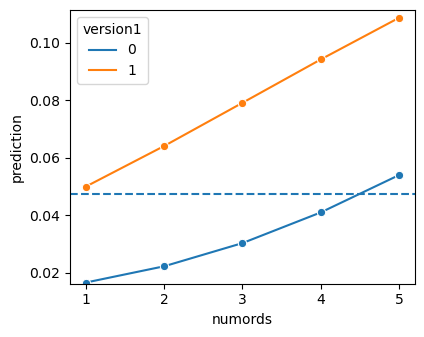

In [132]:
# zb = [f"zip_bins_{i}" for i in range(2, 21)]
intuit
# rsm.pred_plot_sk(clf, pd.concat([intuit75k[["res1_yes"]], Xs], axis=1)[intuit75k.training == 1], incl=[], incl_int="numords:version1", rvar = "res1_yes", transformed=zb)
# rsm.pred_plot_sk(clf, intuit75k[intuit75k.training == 1], incl=[], incl_int="numords:version1", rvar = "res1_yes") #, transformed=zb)


In [171]:
rsm.scale_df(intuit75k)

,id,zip5,zip_bins,sex,bizflag,numords,dollars,last,sincepurch,version1,owntaxprod,upgraded,res1,res2,training,res1_yes,res2_yes,zip801,zip804,res1_train
0,-0.866014,94553,18,Male,0,-0.030725,0.101058,-0.568112,-0.182380,0,0,0,No,No,1,0,0,0,0,0.0
1,-0.865991,53190,10,Unknown,0,-0.433513,-0.145231,-0.620528,-0.631202,0,0,0,No,No,0,0,0,0,0,NaN
2,-0.865968,37091,8,Male,0,0.774852,-0.000536,-0.096364,0.665395,0,0,1,No,No,0,0,0,0,0,NaN
3,-0.865945,02125,1,Male,0,-0.433513,-0.437700,0.060886,-0.730940,0,0,0,No,No,1,0,0,0,0,0.0
4,-0.865921,60201,11,Male,0,-0.433513,-0.422307,-0.725361,-0.631202,0,0,0,No,No,0,0,0,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74995,0.865921,28205,6,Male,1,0.774852,0.729095,-0.568112,-0.032773,0,0,0,Yes,No,1,1,0,0,0,1.0
74996,0.865945,94806,18,Male,0,-0.433513,-0.545451,1.004381,0.914741,1,0,0,No,No,1,0,0,0,0,0.0
74997,0.865968,72958,13,Female,1,-0.433513,-0.237590,-0.620528,0.166704,1,0,0,No,No,1,0,0,0,0,0.0
74998,0.865991,29464,6,Male,0,-0.433513,-0.145231,0.218135,0.565657,0,0,1,No,No,1,0,0,0,0,0.0


In [ ]:
intuit75k_std = rsm.scale_df(intuit75k.loc[:, "zip_bins":], sf=1, train=intuit75k.training == 1, excl = ["sex", "bizflag", "version1", "owntaxprod", "upgraded", "training", "res1_yes", "res2_yes", "zip801", "zip804"])
rsm.pred_plot_sk(clf, intuit75k_std[intuit75k.training == 1], incl=[], rvar="res1_yes", incl_int="numords:version1")

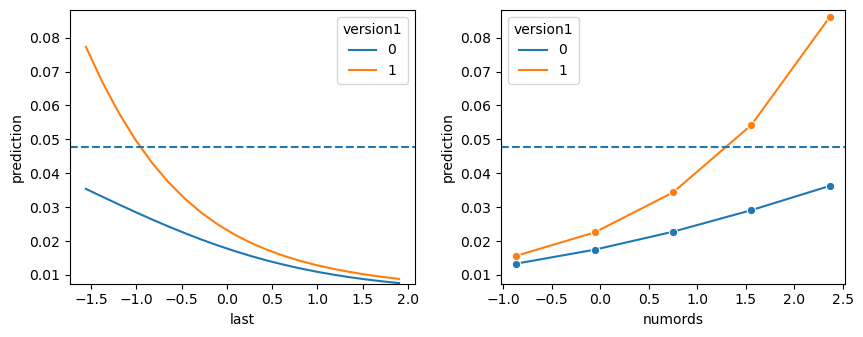

In [163]:
rsm.pred_plot_sk(
    clf, intuit75k_std[intuit75k.training == 1], incl=[], 
    rvar="res1_yes", incl_int=["last:version1", "numords:version1"]
)

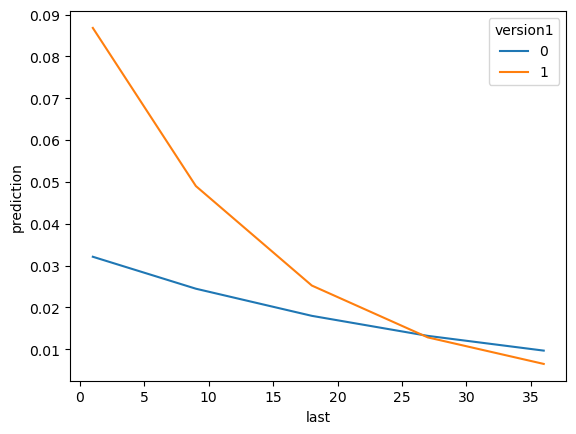

In [154]:
iplot = rsm.sim_prediction(intuit75k.query("training == 1"), vary=["last", "version1"])
iplot["prediction"] = lr.predict(iplot)
fig = sns.lineplot(x="last", y="prediction", hue="version1", data=iplot)

In [155]:
# completing the pred df
pred["baselogit"] = lr_base.predict(intuit75k)
pred["logit"] = lr.predict(intuit75k)

In [156]:
intuit75k["res1_train"] = rsm.ifelse(
    intuit75k.training == 1, intuit75k.res1_yes, np.nan
)

In [157]:
intuit75k["res1_train"] = rsm.ifelse(
    intuit75k.training == 1, intuit75k.res1_yes, np.nan
)
pred["res1"] = intuit75k["res1"]
pred["res2"] = intuit75k["res2"]
pred["spam"] = 1
pred["ensemble"] = (pred.nn1 + pred.nn2 + pred.nn3 + pred.logit) / 4

In [158]:
# adding mailto variables
adj_be = 1.41 / (60 * 0.5)
pred["mailto_baselogit"] = pred["baselogit"] > adj_be
pred["mailto_logit"] = pred["logit"] > adj_be
pred["mailto_nn1"] = pred["nn1"] > adj_be
pred["mailto_nn2"] = pred["nn2"] > adj_be
pred["mailto_nn3"] = pred["nn3"] > adj_be
pred["mailto_nn4"] = pred["nn4"] > adj_be
pred["mailto_nn10"] = pred["nn10"] > adj_be
pred["mailto_spam"] = True
pred["mailto_ensemble"] = pred["ensemble"] > adj_be

In [159]:
MAILING_COST = 1.41
MARGIN = 60


def perf_calc(dat, pred, mail, intro, perf="res1", lev="Yes", nr_cust=801821 - 38487):

    if perf == "res1":
        dat = dat[dat.training == 0]
    else:
        dat = dat[(dat.training == 0) & (dat.res1 == "No")]

    perc_mail = np.nanmean(dat[mail])
    rep_rate = np.nanmean(dat.loc[dat[mail], perf] == lev)


    auc = rsm.auc(rsm.ifelse(dat[perf] == lev, 1, 0), dat[pred])

    ## only needed for res1 because what is in res2 is what really happended
    if perf == "res1":
        rep_rate = rep_rate * 0.5

    nr_mail = round(nr_cust * perc_mail, 0)
    nr_resp = round(nr_mail * rep_rate, 0)

    mail_cost = MAILING_COST * nr_mail
    revenue = MARGIN * nr_resp
    profit = revenue - mail_cost
    ROME = profit / mail_cost

    prn = f"""
      - {intro} the number of customers Intuit should mail is {(nr_mail):,.0f} ({100 * perc_mail:.2f}%)
      - The response rate for the selected customers is predicted to be {100 * rep_rate:.2f}% or {nr_resp:,.0f} buyers
      - The revenue is equal to ${revenue:,.2f} with a COGS equal to ${revenue * .5:,.2f}
      - The expected profit is ${profit:,.2f}
      - The mailing cost is estimated to be ${mail_cost:,.2f} with a ROME of {100 * ROME:.2f}%
      """

    print(prn)

    return profit, ROME, auc

In [ ]:
pred["mailto_spam"] = True
profit_nt1, ROME_nt1, auc_nt1 = perf_calc(
    pred, "spam", "mailto_spam", "Based on a spamming approach"
)
profit_nt2, ROME_nt2, auc_nt2 = perf_calc(
    pred, "spam", "mailto_spam", "Based on a spamming approach", perf="res2"
)

In [ ]:
profit_bl1, ROME_bl1, auc_bl1 = perf_calc(
    pred, "baselogit", "mailto_baselogit", "Based on the base logit model"
)
profit_bl2, ROME_bl2, auc_bl2 = perf_calc(
    pred, "baselogit", "mailto_baselogit", "Based on the base logit model", perf="res2"
)

In [ ]:
profit_l1, ROME_l1, auc_l1 = perf_calc(
    pred, "logit", "mailto_logit", "Based on the final logit model"
)
profit_l2, ROME_l2, auc_l2 = perf_calc(
    pred, "logit", "mailto_logit", "Based on the final logit model", perf="res2"
)

In [ ]:
profit_nn1_1, ROME_nn1_1, auc_nn1_1 = perf_calc(
    pred,
    "nn1",
    "mailto_nn1",
    "Based on a neural network with one node in the hidden layer",
)
profit_nn1_2, ROME_nn1_2, auc_nn1_2 = perf_calc(
    pred,
    "nn1",
    "mailto_nn1",
    "Based on a neural network with one node in the hidden layer",
    perf="res2",
)

In [ ]:
profit_nn2_1, ROME_nn2_1, auc_nn2_1 = perf_calc(
    pred,
    "nn2",
    "mailto_nn2",
    "Based on a neural network with two nodes in the hidden layer",
)
profit_nn2_2, ROME_nn2_2, auc_nn2_2 = perf_calc(
    pred,
    "nn2",
    "mailto_nn2",
    "Based on a neural network with two nodes in the hidden layer",
    perf="res2",
)

In [ ]:
profit_nn3_1, ROME_nn3_1, auc_nn3_1 = perf_calc(
    pred,
    "nn3",
    "mailto_nn3",
    "Based on a neural network with three nodes in the hidden layer",
)
profit_nn3_2, ROME_nn3_2, auc_nn3_2 = perf_calc(
    pred,
    "nn3",
    "mailto_nn3",
    "Based on a neural network with three nodes in the hidden layer",
    perf="res2",
)

In [ ]:
profit_nn4_1, ROME_nn4_1, auc_nn4_1 = perf_calc(
    pred,
    "nn4",
    "mailto_nn4",
    "Based on a neural network with four nodes in the hidden layer",
)
profit_nn4_2, ROME_nn4_2, auc_nn4_2 = perf_calc(
    pred,
    "nn4",
    "mailto_nn4",
    "Based on a neural network with four nodes in the hidden layer",
    perf="res2",
)

In [ ]:
profit_nn10_1, ROME_nn10_1, auc_nn10_1 = perf_calc(
    pred,
    "nn10",
    "mailto_nn10",
    "Based on a neural network with ten nodes in the hidden layer",
)
profit_nn10_2, ROME_nn10_2, auc_nn10_2 = perf_calc(
    pred,
    "nn10",
    "mailto_nn10",
    "Based on a neural network with ten nodes in the hidden layer",
    perf="res2",
)

In [ ]:
profit_en1, ROME_en1, auc_en1 = perf_calc(
    pred, "ensemble", "mailto_ensemble", "Based on an esemble of logistic and nn models"
)
profit_en2, ROME_en2, auc_en2 = perf_calc(
    pred,
    "ensemble",
    "mailto_ensemble",
    "Based on an esemble of logistic and nn models",
    perf="res2",
)

In [ ]:
# plt.figure(figsize=(4, 4))
fig = rsm.gains_plot(pred[pred.training == 1], "res1", "Yes", ["nn2", "nn10"])

In [ ]:
# plt.figure(figsize=(4, 4))
fig = rsm.gains_plot(pred[pred.training == 0], "res1", "Yes", ["nn2", "nn10"])

In [ ]:
# plt.figure(figsize=(4, 4))
dct = {"train": pred[pred.training == 1], "test": pred[pred.training == 0]}
fig = rsm.gains_plot(dct, "res1", "Yes", "nn10")

In [ ]:
fig = rsm.profit_plot(pred[pred.training == 1], 'res1', "Yes", 'logit', qnt = 10, cost = 1.41, margin = 30, contact = True)

In [ ]:
fig = rsm.expected_profit_plot(pred[pred.training == 1], 'res1', "Yes", 'logit', cost = 1.41, margin = 30, contact = True)

In [ ]:
pred["mailto_logit"] = pred["logit"] > 1.41 / 60
pd.crosstab(
    pred.loc[pred.training == 0, "mailto_logit"],
    pred.loc[pred.training == 0, "res1"],
    margins=True,
    margins_name="Total",
)

In [ ]:
pred["mailto_logit"] = pred["logit"] > 1.41 / (60 * 0.5)
pd.crosstab(
    pred.loc[pred.training == 0, "mailto_logit"],
    pred.loc[pred.training == 0, "res1"],
    margins=True,
    margins_name="Total",
)

In [ ]:
intuit75k["res1_yes"].mean()

In [ ]:
pred[pred.training == 0].groupby("mailto_logit")[["mailto_logit"]].agg(
    "count"
).transform(lambda x: (100 * x / x.sum()).round(2).astype(str) + "%")

In [ ]:
pred["mailto_logit"] = pred["logit"] > 1.41 / (60 * 0.5)
(
    pd.crosstab(
        pred.loc[pred.training == 0, "mailto_logit"],
        pred.loc[pred.training == 0, "res1"],
        margins=True,
        margins_name="Total",
        normalize="index",
    ).assign(Total=1)
    * 100
).round(2).astype(str) + "%"

In [ ]:
dat1 = pd.DataFrame(
    {
        "name": [
            "Spam",
            "nn1",
            "nn2",
            "nn3",
            "nn4",
            "nn10",
            "baselogit",
            "logit",
            "ensemble",
        ],
        "Profit": [
            profit_nt1,
            profit_nn1_1,
            profit_nn2_1,
            profit_nn3_1,
            profit_nn4_1,
            profit_nn10_1,
            profit_bl1,
            profit_l1,
            profit_en1,
        ],
        "ROME": [
            ROME_nt1,
            ROME_nn1_1,
            ROME_nn2_1,
            ROME_nn3_1,
            ROME_nn4_1,
            ROME_nn10_1,
            ROME_bl1,
            ROME_l1,
            ROME_en1,
        ],
        "AUC": [
            auc_nt1,
            auc_nn1_1,
            auc_nn2_1,
            auc_nn3_1,
            auc_nn4_1,
            auc_nn10_1,
            auc_bl1,
            auc_l1,
            auc_en1,
        ],
    }
)

In [ ]:
dat = dat1.sort_values("Profit").reset_index(drop=True)
dat

In [ ]:
plt.figure(figsize=(11, 5))
fig = sns.barplot(x="name", y="Profit", color="slateblue", data=dat)
fig.set(xlabel="", ylabel="Profit", title="Campaign profit")
for index, row in dat.iterrows():
    fig.text(
        row.name, row.Profit - 20000, f"{row.Profit:,.0f}", ha="center", color="white"
    )

In [ ]:
plt.figure(figsize=(12, 5))
fig = sns.barplot(x="name", y="ROME", color="slateblue", data=dat)
fig.set(xlabel="", title="Return on Marketing Expenditures (ROME)")
for index, row in dat.iterrows():
    fig.text(
        row.name,
        row.ROME - 0.05,
        f"{round((100*row.ROME), 2):,}%",
        ha="center",
        color="white",
    )

In [ ]:
dat = dat1.sort_values("AUC").reset_index(drop=True)
plt.figure(figsize=(12, 5))
fig = sns.barplot(x="name", y="AUC", color="slateblue", data=dat)
fig.set(xlabel="", title="Area Under the ROC Curve (AUC)")
for index, row in dat.iterrows():
    fig.text(
        row.name,
        row.AUC - 0.04,
        f"{round((100*row.AUC), 2):,}%",
        ha="center",
        color="white",
    )

In [ ]:
dat2 = pd.DataFrame(
    {
        "name": [
            "Spam",
            "nn1",
            "nn2",
            "nn3",
            "nn4",
            "nn10",
            "baselogit",
            "logit",
            "ensemble",
        ],
        "Profit": [
            profit_nt2,
            profit_nn1_2,
            profit_nn2_2,
            profit_nn3_2,
            profit_nn4_2,
            profit_nn10_2,
            profit_bl2,
            profit_l2,
            profit_en2,
        ],
        "ROME": [
            ROME_nt2,
            ROME_nn1_2,
            ROME_nn2_2,
            ROME_nn3_2,
            ROME_nn4_2,
            ROME_nn10_2,
            ROME_bl2,
            ROME_l2,
            ROME_en2,
        ],
        "AUC": [
            auc_nt2,
            auc_nn1_2,
            auc_nn2_2,
            auc_nn3_2,
            auc_nn4_2,
            auc_nn10_2,
            auc_bl2,
            auc_l2,
            auc_en2,
        ],
    }
)

In [ ]:
dat = dat2.sort_values("Profit").reset_index(drop=True)
dat

In [ ]:
plt.figure(figsize=(11, 5))
fig = sns.barplot(x="name", y="Profit", color="slateblue", data=dat)
fig.set(xlabel="", ylabel="Profit", title="Campaign profit")
for index, row in dat.iterrows():
    fig.text(
        row.name, row.Profit - 20000, f"{row.Profit:,.0f}", ha="center", color="white"
    )

In [ ]:
plt.figure(figsize=(12, 5))
fig = sns.barplot(x="name", y="ROME", color="slateblue", data=dat)
fig.set(xlabel="", title="Return on Marketing Expenditures (ROME)")
for index, row in dat.iterrows():
    fig.text(
        row.name,
        row.ROME - 0.05,
        f"{round((100*row.ROME), 2):,}%",
        ha="center",
        color="white",
    )

In [ ]:
dat = dat1.sort_values("AUC").reset_index(drop=True)
plt.figure(figsize=(12, 5))
fig = sns.barplot(x="name", y="AUC", color="slateblue", data=dat)
fig.set(xlabel="", title="Area Under the ROC Curve (AUC)")
for index, row in dat.iterrows():
    fig.text(
        row.name,
        row.AUC - 0.04,
        f"{round((100*row.AUC), 2):,}%",
        ha="center",
        color="white",
    )

In [ ]:
pred["id"] = intuit75k["id"]
pred[["id", "mailto_ensemble", "res1", "res2", "training"]].to_csv(
    "../../intuit-submissions/prof-py/go-prof.csv", index=False
)

In [ ]:
--- do not use below ---

In [ ]:
pred["res2"] = intuit75k["res2"]
y2n = pred[
    [
        "res2",
        "mailto_logit",
        "mailto_nn2",
        "mailto_nn1",
        "mailto_nn2",
        "mailto_nn3",
        "mailto_ensemble",
    ]
].query(
    "(res2 == 'Yes') & (mailto_nn2 | mailto_logit) & ((mailto_nn1 == False) | (mailto_nn3 == False))"
)
y2n.index

In [ ]:
n2y = pred[
    [
        "res2",
        "mailto_nn2",
        "mailto_logit",
        "mailto_nn1",
        "mailto_nn2",
        "mailto_nn3",
        "mailto_ensemble",
    ]
].query(
    "(res2 == 'No') & ((mailto_nn2 == False) | (mailto_logit == False)) & (mailto_nn1 | mailto_nn2)"
)
n2y.index

In [ ]:
np.random.seed(1234)
pred.loc[np.random.choice(n2y.index, 30), "res2"] = "Yes"
pred.loc[np.random.choice(y2n.index, 30), "res2"] = "No"

In [ ]:
pred["ensemble"] = (pred.nn1 + pred.nn2 + pred.nn3 + pred.logit) / 4

In [ ]:
# adding mailto variables
adj_be = 1.41 / (60 * 0.5)
pred["mailto_nn1"] = pred["nn1"] > adj_be
pred["mailto_nn2"] = pred["nn2"] > adj_be
# pred["mailto_nn3"] = pred["nn3"] > adj_be
# pred["mailto_nn4"] = pred["nn4"] > adj_be
# pred["mailto_ensemble"] = pred["ensemble"] > adj_be

In [ ]:
profit_nn1_1, ROME_nn1_1, auc_nn1_1 = perf_calc(
    pred,
    "nn1",
    "mailto_nn1",
    "Based on a neural network with one node in the hidden layer",
)
profit_nn1_2, ROME_nn1_2, auc_nn1_2 = perf_calc(
    pred,
    "nn1",
    "mailto_nn1",
    "Based on a neural network with one node in the hidden layer",
    perf="res2",
)

In [ ]:
profit_nn2_1, ROME_nn2_1, auc_nn2_1 = perf_calc(
    pred,
    "nn2",
    "mailto_nn2",
    "Based on a neural network with two nodes in the hidden layer",
)
profit_nn2_2, ROME_nn2_2, auc_nn2_2 = perf_calc(
    pred,
    "nn2",
    "mailto_nn2",
    "Based on a neural network with two nodes in the hidden layer",
    perf="res2",
)

In [ ]:
profit_nn3_1, ROME_nn3_1, auc_nn3_1 = perf_calc(
    pred,
    "nn3",
    "mailto_nn3",
    "Based on a neural network with three nodes in the hidden layer",
)
profit_nn3_2, ROME_nn3_2, auc_nn3_2 = perf_calc(
    pred,
    "nn3",
    "mailto_nn3",
    "Based on a neural network with three nodes in the hidden layer",
    perf="res2",
)

In [ ]:
profit_en1, ROME_en1, auc_en1 = perf_calc(
    pred, "ensemble", "mailto_ensemble", "Based on an esemble of logistic and nn models"
)
profit_en2, ROME_en2, auc_en2 = perf_calc(
    pred,
    "ensemble",
    "mailto_ensemble",
    "Based on an esemble of logistic and nn models",
    perf="res2",
)

In [ ]:
profit_l1, ROME_l1, auc_l1 = perf_calc(
    pred, "logit", "mailto_logit", "Based on the final logit model"
)
profit_l2, ROME_l2, auc_l2 = perf_calc(
    pred, "logit", "mailto_logit", "Based on the final logit model", perf="res2"
)

In [ ]:
rsm.profit(
    pred.loc[pred.training == 0, "res1"],
    pred.loc[pred.training == 0, "logit"],
    "Yes",
    1.41,
    30,
)